# Programming Exercise 4: Neural Networks Learning¶

In this exercise, i will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

In [2]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
import utils
import pandas as pd
grader = utils.Grader()

%matplotlib inline

## Neural Networks
In the previous exercise, i implemented feedforward propagation for neural networks and used it to predict handwritten digits with the already provided weights. In this exercise, i will implement the backpropagation algorithm to learn the parameters for the neural network.

Start the exercise by first loading the dataset.

In [3]:
data = loadmat(os.path.join('Data', 'ex4data1.mat'))
X, y = data['X'], data['y']

y[y==10] = 0

m = y.size
print(X.shape)
print(y.shape)

(5000, 400)
(5000, 1)


## Visualizing the data

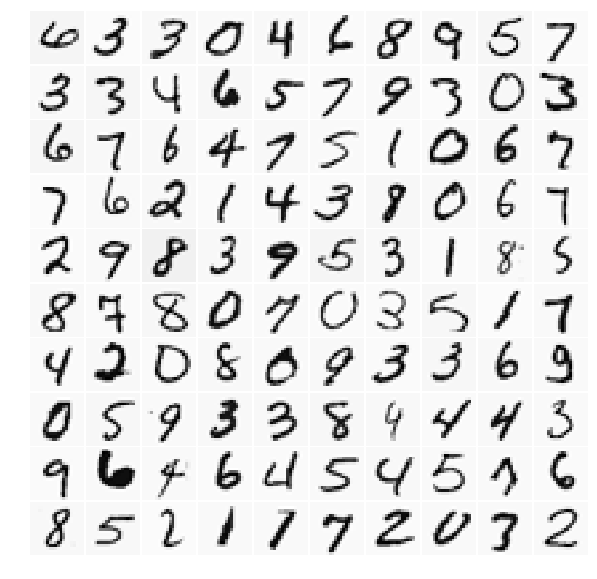

In [4]:
rand_indices = np.random.choice(m, 100, replace = False)
sel = X[rand_indices, :]

utils.displayData(sel)

## 1.2 Model representation
Our neural network is shown in the following figure.

![Neural Network](Figures/neural_network.png)

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that inputs are pixel values of digit images. Since the images are of size $20 \times 20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables X and y above.

You have been provided with a set of network parameters ($\Theta^{(1)}, \Theta^{(2)}$) already trained by us. These are stored in ex4weights.mat and will be loaded in the next cell of this notebook into Theta1 and Theta2. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [5]:

# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat(os.path.join('Data', 'ex4weights.mat'))

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

## 1.3 Feedforward and cost function
Now you will implement the cost function and gradient for the neural network. First, complete the code for the function nnCostFunction in the next cell to return the cost.

Recall that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$
where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$
For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

Implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. Your code should also work for a dataset of any size, with any number of labels (you can assume that there are always at least $K \ge 3$ labels).

In [6]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):

    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape) #25x401
    Theta2_grad = np.zeros(Theta2.shape) #10x26
    
    #================== Feed-forward =====================
    
    X = np.concatenate([np.ones((m,1)), X], axis = 1)
    a1 = X
    z2 = a1 @ Theta1.T #5000x25
    a2 = utils.sigmoid(z2) 
    a2 = np.hstack((np.ones((m,1)), a2)) 
    z3 = a2 @ Theta2.T #5000x10
    h = utils.sigmoid(z3) 
    
    # to create a 5000x10 matrix as output
    y_d = pd.get_dummies(y.flatten())

    temp1 = np.multiply(y_d, np.log(h)) # 5000x10
    temp2 = np.multiply(1 - y_d, np.log(1 - h))
    temp3 = np.sum(temp1 + temp2)
    
    
    # ============ Cost Function Regularization ============
    
    sum1 = np.sum(np.sum(np.power(Theta1[:,1:], 2), axis = 1))
    sum2 = np.sum(np.sum(np.power(Theta2[:,1:], 2), axis = 1))
    
    #==================== Cost Function ====================
    
    J = np.sum(temp3 / (-m)) + (sum1 + sum2)*lambda_/(2*m)
    
    #=================== Backpropagation ===================
    delta1 = 0
    delta2 = 0
    
    d3 = h - y_d # 5000x10
    z2 = np.hstack((np.ones((m,1)), z2))
    d2 = np.multiply(d3 @ Theta2, sigmoidGradient(z2)) # 5000x26
    
    delta1 += np.dot((d2.iloc[:, 1:]).T, a1)
    delta2 += np.dot(d3.T, a2)
    
    Theta1_grad = delta1/m
    Theta2_grad = delta2/m
    
    #============= Gradient Regularization =================
    
    Theta1_grad[:,1:] += (lambda_/m)*Theta1[:,1:]
    Theta2_grad[:,1:] += (lambda_/m)*Theta2[:,1:]

    # Unroll gradients
    #grad = np.concatenate([Theta1_grad.ravel(order=order), Theta2_grad.ravel(order=order)])
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    return J, grad

Once you are done, call your nnCostFunction using the loaded set of parameters for Theta1 and Theta2. You should see that the cost is about 0.287629.

In [7]:
lambda_ = 0
J,grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)
print('The cost should be about                   : 0.287629.')
print(grad)

Cost at parameters (loaded from ex4weights): 0.287629 
The cost should be about                   : 0.287629.
[6.18712766e-05 0.00000000e+00 0.00000000e+00 ... 5.00631408e-04
 1.13453370e-03 1.35707295e-03]


## 1.4 Regularized cost function
The cost function for neural networks with regularization is given by:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$
You can assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. However, code should work for any number of input units, hidden units and outputs units. Note that you should not be regularizing the terms that correspond to the bias. Notice that you can first compute the unregularized cost function $J$ using your existing nnCostFunction and then later add the cost for the regularization terms.

Once done, the next cell will call nnCostFunction using the loaded set of parameters for Theta1 and Theta2, and $\lambda = 1$. The cost should be about 0.383770.

In [8]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

Cost at parameters (loaded from ex4weights): 0.383770
This value should be about                 : 0.383770.


# 2 Backpropagation
In this part of the exercise, i will implement the backpropagation algorithm to compute the gradient for the neural network cost function. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(\theta)$ using an advanced optimizer such as scipy's optimize.minimize. I will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. After verifying that gradient computation for the unregularized case is correct, i will implement the gradient for the regularized neural network.


## 2.1 Sigmoid Gradient
The gradient for the sigmoid function can be computed as

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$
where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

In [9]:

def sigmoidGradient(z):

    g = np.zeros(z.shape)

    # ============================================================

    g = np.multiply(utils.sigmoid(z), 1-utils.sigmoid(z))


    # =============================================================
    return g

In [10]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


## 2.2 Random Initialization
When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{l}$.
Your job is to complete the function randInitializeWeights to initialize the weights for $\Theta$. Modify the function by filling in the following code:

```python
Randomly initialize the weights to small values
W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init ```

Note that we give the function an argument for $\epsilon$ with default value epsilon_init = 0.12.

In [11]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):

    # You need to return the following variables correctly 
    W = np.zeros((L_out, 1 + L_in))

    # ======================================
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    
    return W

In [12]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


## 2.4 Backpropagation


Now, i will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta_j^{(l)}$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$. In detail, here is the backpropagation algorithm (also depicted in the figure above).

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a +1 term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In numpy, if a 1 is a column matrix, adding one corresponds to a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1).


2. For each output unit $k$ in layer 3 (the output layer), set $$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$ where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).

3. For the hidden layer $l = 2$, set $$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$ Note that the symbol $*$ performs element wise multiplication in numpy.

4. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$. In numpy, removing $\delta_0^{(2)}$ corresponds to delta_2 = delta_2[1:].

5. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$: $$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

*Python/Numpy tip: You should implement the backpropagation algorithm only after you have successfully completed the feedforward and cost functions. While implementing the backpropagation alogrithm, it is often useful to use the `shape` function to print out the shapes of the variables you are working with if you run into dimension mismatch errors.*

## 2.4 Gradient checking
In neural networks, you are minimizing the cost function $J(\Theta)$. To perform gradient checking on your parameters, you can imagine “unrolling” the parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\theta$. By doing so, you can think of the cost function being $J(\Theta)$ instead and use the following gradient checking procedure.

Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial \theta_i} J(\theta)$; you’d like to check if $f_i$ is outputting correct derivative values.

$$
\text{Let } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
\quad \text{and} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
$$
So, $\theta^{(i+)}$ is the same as $\theta$, except its $i^{th}$ element has been incremented by $\epsilon$. Similarly, $\theta^{(i-)}$ is the corresponding vector with the $i^{th}$ element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$’s correctness by checking, for each $i$, that:

$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$
The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{-4}$, you’ll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more)

In [13]:
utils.checkNNGradients(nnCostFunction)

[[-9.27825235e-03 -9.27825236e-03]
 [-3.04978709e-06 -3.04978914e-06]
 [-1.75060084e-04 -1.75060082e-04]
 [-9.62660618e-05 -9.62660620e-05]
 [ 8.89911959e-03  8.89911960e-03]
 [ 1.42869405e-05  1.42869443e-05]
 [ 2.33146356e-04  2.33146357e-04]
 [ 1.17982666e-04  1.17982666e-04]
 [-8.36010761e-03 -8.36010762e-03]
 [-2.59383093e-05 -2.59383100e-05]
 [-2.87468729e-04 -2.87468729e-04]
 [-1.37149705e-04 -1.37149706e-04]
 [ 7.62813550e-03  7.62813551e-03]
 [ 3.69883213e-05  3.69883234e-05]
 [ 3.35320347e-04  3.35320347e-04]
 [ 1.53247079e-04  1.53247082e-04]
 [-6.74798369e-03 -6.74798370e-03]
 [-4.68759787e-05 -4.68759769e-05]
 [-3.76215585e-04 -3.76215587e-04]
 [-1.66560297e-04 -1.66560294e-04]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.64090819e-01  1.64090819e-01]
 [ 1.64567932e-01  1.64567932e-01]
 [ 1.58339334e-01  1.58339334e-01]
 [ 1.51127527e-01  1.51127527e-01]
 [ 1.49568335e-01  1.49568335e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 5.75736494e-02  5.75736493e-02]
 [ 5.77867378e-02  5

## 2.5 Regularized Neural Network
After you have successfully implemented the backpropagation algorithm, you can add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term after computing the gradients using backpropagation.

Specifically, after you have computed $\Delta_{ij}^{(l)}$ using backpropagation, you should add regularization using

$$ \begin{align} 
&amp; \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} &amp; \qquad \text{for } j = 0 \\
&amp; \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} &amp; \qquad \text{for } j \ge 1
\end{align}
$$
Note that you should not be regularizing the first column of $\Theta^{(l)}$ which is used for the bias term. Furthermore, in the parameters $\Theta_{ij}^{(l)}$, $i$ is indexed starting from 1, and $j$ is indexed starting from 0. Thus,

$$
\Theta^{(l)} = \begin{bmatrix}
\Theta_{1,0}^{(i)} &amp; \Theta_{1,1}^{(l)} &amp; \cdots \\
\Theta_{2,0}^{(i)} &amp; \Theta_{2,1}^{(l)} &amp; \cdots \\
\vdots &amp;  ~ &amp; \ddots
\end{bmatrix}
$$


You should expect to see a relative difference that is less than 1e-9.

In [ ]:
#  Check gradients by running checkNNGradients
lambda_ = 3
utils.checkNNGradients(nnCostFunction, lambda_)

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')


Cost at (fixed) debugging parameters (w/ lambda = 3.000000): 0.576051 
(for lambda = 3, this value should be about 0.576051)

## 2.6 Learning parameters using scipy.optimize.minimize
After you have successfully implemented the neural network cost function and gradient computation, the next step we will use  scipy's minimization to learn a good set parameters.

In [15]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 100}

#  You should also try different values of lambda
lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

After the training completes, we will proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct. If your implementation is correct, you should see a reported training accuracy of about 95.3% (this may vary by about 1% due to the random initialization). It is possible to get higher training accuracies by training the neural network for more iterations. We encourage you to try training the neural network for more iterations (e.g., set maxiter to 400) and also vary the regularization parameter $\lambda$. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.

In [16]:
pred = utils.predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 10.000000


# 3 Visualizing the Hidden Layer
One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value ($a_i^{(l)}$) close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the “representation” captured by the hidden unit is to reshape this 400 dimensional vector into a 20 × 20 image and display it (It turns out that this is equivalent to finding the input that gives the highest activation for the hidden unit, given a “norm” constraint on the input (i.e., $||x||_2 \le 1$)).

The next cell does this by using the displayData function and it will show you an image with 25 units, each corresponding to one hidden unit in the network. In your trained network, you should find that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.

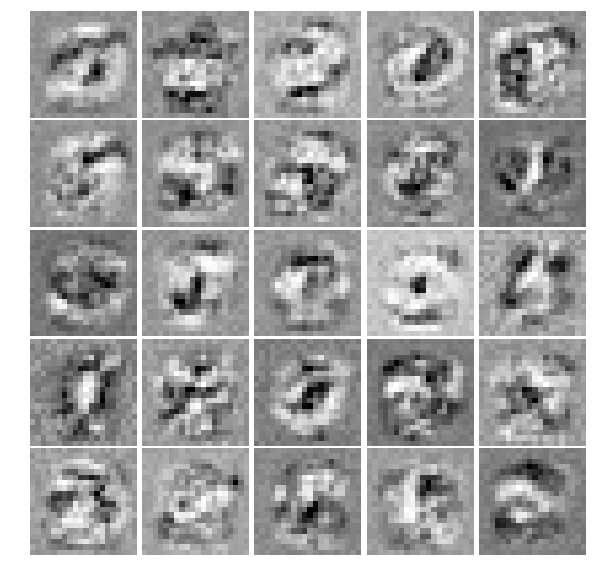

In [17]:
utils.displayData(Theta1[:, 1:])